### todo list:

- Identify if are there communities in the graph
- analyse if the members of each community have some common characteristics
- Are there any hub nodes, that is any node with a particularly big number of connections to the others
- Are you able to simulate the spread of the fake news in the population?
- Is there any difference in the mean speed of the spread if the infection starts from each of the identified communities?

### tl;dr

- 3 (or 4) communities
- communities are age-based
- node *35* has highest degree and node *43* has highest closeness
- yes
- ...

In [1]:
def leaf(name):
    fig.savefig('monalisa-svg/'+name+'.svg', dpi=150, format='svg', transparent=True, pad_inches=0.10)
sq_leaf = (10.0, 6.0)

# thick fat code

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import community as cmy
from community import community_louvain
import matplotlib.ticker as ticker
import numpy as np
import random
options = {
    "font_size": 8,
    "node_size": 300,
    "edgecolors": "black",
    "linewidths": 1,
    "width": 1,
}

In [3]:
people = nx.read_gml('graph1.gml', label='name')

catch a first look to our people:

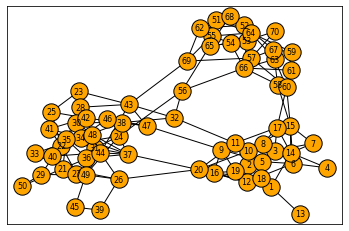

In [4]:
nx.draw_networkx(people, node_color="orange", **options)

beautifier snippets, ignore it (thanks to Paul Brodersen 👏🏽👏🏽👏🏽 )

In [5]:
def community_layout(g, partition):
    pos_communities = _position_communities(g, partition, scale=3.0)
    pos_nodes = _position_nodes(g, partition, scale=1.5)
    pos = dict()
    for node in g.nodes():
        pos[node] = pos_communities[node] + pos_nodes[node]
    return pos

def _position_communities(g, partition, **kwargs):
    between_community_edges = _find_between_community_edges(g, partition)
    communities = set(partition.values())
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))
    pos_communities = nx.spring_layout(hypergraph, **kwargs)
    pos = dict()
    for node, community in partition.items():
        pos[node] = pos_communities[community]
    return pos

def _find_between_community_edges(g, partition):
    edges = dict()
    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]
        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]
    return edges

def _position_nodes(g, partition, **kwargs):
    communities = dict()
    for node, community in partition.items():
        try:
            communities[community] += [node]
        except KeyError:
            communities[community] = [node]
    pos = dict()
    for ci, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        pos_subgraph = nx.spring_layout(subgraph, **kwargs)
        pos.update(pos_subgraph)
    return pos

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
# import matplotlib.cm as cm
# pos = nx.spring_layout(people)
# cmap = cm.get_cmap('viridis', max(communities.values()) + 1)
# nx.draw_networkx_nodes(people, pos, communities.keys(), node_size=40,cmap=cmap, node_color=list(communities.values()))
# nx.draw_networkx_edges(people, pos, alpha=0.5)
# plt.show()

## community analysis

everyone 💕 Louvain algorithm

In [6]:
communities = community_louvain.best_partition(people, resolution=1.00) # res = 1.00 aka newman algorithm (fixed modularity)  // res = 1.75 aka louvain power💚
how_many = len(set(communities.values()))

let's draw communities

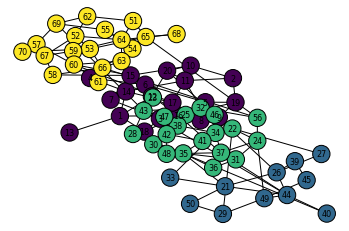

In [7]:
pos = community_layout(people, communities)
nx.draw_networkx(people, pos, node_color=list(communities.values()), **options)

# ax.margins(0.20)
plt.axis("off")
plt.show()

how many nodes inside each community?

In [8]:
# louvain
l = list(communities.values())
[l.count(i) for i in set(l)]

[20, 11, 20, 19]

In [9]:
# modularity
l = cmy.greedy_modularity_communities(people)
[len(i) for i in l]

[20, 20, 19, 11]

In [10]:
# overrride with greedy modularity

# tmp = [list(i) for i in l]
# communities = {v:i for i in range(len(tmp)) for v in tmp[i]}
# how_many = len(set(communities.values()))

In [11]:
# shitty 3-clique
[len(i) for i in list(cmy.k_clique_communities(people, 3))]

[7, 3, 4, 5, 3, 4, 3, 4, 3, 3]

***this graph could be clustered in 3 or 4 heterogeneous communities***

generate community subgraphs

In [12]:
subgraphs = {str(i):people.subgraph([k for k in communities if communities[k]==i]) for i in range(how_many)}
subgraphs['people'] = people

compute assortativity foreach attribute

In [13]:
age_ass = [round(nx.numeric_assortativity_coefficient(subgraphs[i], "age"),2) for i in subgraphs]
gender_ass = [round(nx.attribute_assortativity_coefficient(subgraphs[i], "gender"),2) for i in subgraphs]
degree_ass = [round(nx.degree_assortativity_coefficient(subgraphs[i]),2) for i in subgraphs]

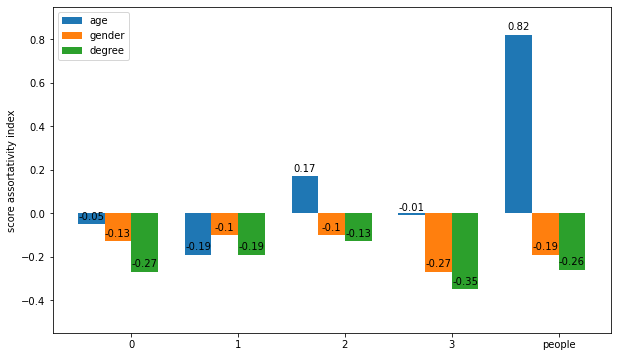

In [14]:
labels = [k for k in subgraphs]
x = np.arange(len(labels))
width = 0.25

fig = plt.figure(figsize=sq_leaf)
ax = fig.gca()

rect_age = ax.bar(x - 1.5*width, age_ass, width, label='age')
rect_gender = ax.bar(x - 0.5*width, gender_ass, width, label='gender')
rect_degree = ax.bar(x + 0.5*width, degree_ass, width, label='degree')

ax.set_ylabel('score assortativity index')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc=2)
ax.set_ylim(-0.55,0.95)

autolabel(rect_age)
autolabel(rect_gender)
autolabel(rect_degree)

#fig.tight_layout()
plt.show()
leaf('assortativity-hist')

***communities seems has no preferential attachment based on nodes attributes  
global graph has an high age assortativity instead, thus a strong age homophily may generate communities***

statistical age distribution

In [15]:
ages = [[] for _ in range(how_many)]
for node, age in list(people.nodes('age')):
    ages[communities[node]].append(age)

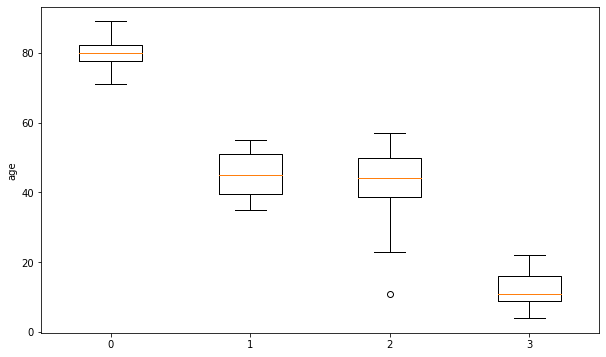

In [16]:
fig = plt.figure(figsize=sq_leaf)
ax = fig.gca()
ax.boxplot(ages)
ax.set_ylabel('age')
ax.set_xticklabels(list(range(how_many)))
plt.show()
leaf('age-clusters-boxplot')

***q.e.d.***

## vip nodes

degree distribution among nodes:

In [17]:
degrees = [v for _,v in people.degree()]
x = list(set(degrees))
y = [degrees.count(i) for i in x]

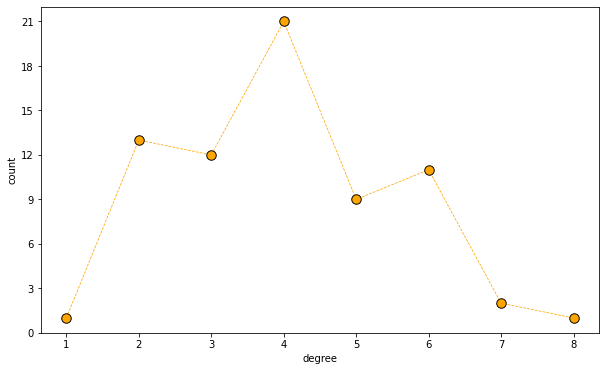

In [18]:
fig = plt.figure(figsize=sq_leaf)
ax = fig.gca()
ax.set_xlabel('degree')
ax.set_ylabel('count')
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.plot(x, y, ls="--", marker='o', lw=0.75, c='orange', mec='black', mew=0.95, mfc='orange', ms=9.5)
plt.show()
leaf('degree-distro')

top degree-centrality nodes 

In [19]:
for k,v in people.degree():
    if v > 6:
        print(k,':',v,'neighbors')

35 : 8 neighbors
37 : 7 neighbors
64 : 7 neighbors


forever alone nodes

In [20]:
for k,v in people.degree():
    if v < 2:
        print(k,':',v,'neighbors')

13 : 1 neighbors


closeness distribution among nodes:

In [21]:
close_dict = nx.closeness_centrality(people)
close_index =  [(k,v) for k,v in sorted(close_dict.items(), key=lambda x: x[1])] #sorting

top 3 🥇

In [22]:
for k,v in close_index[-3:]:
    print(k,':',v,'%')

37 : 0.3399014778325123 %
32 : 0.345 %
43 : 0.3556701030927835 %


worst 3 🪓

In [23]:
for k,v in close_index[:3]:
    print(k,':',v,'%')

13 : 0.22044728434504793 %
68 : 0.22847682119205298 %
45 : 0.23 %


## simulations

perfect simulations require perfect functions 👌🏽✨

In [24]:
def tick_of_clock(G, label='infected'):
    output = {k:1 for k in G.nodes}
    for node in G.nodes:
        if not G.nodes[node][label]: # if not infected
            how_many_infected = 0
            for neighbor in G.neighbors(node):
                how_many_infected += G.nodes[neighbor][label] # count infected neighbors
            if how_many_infected < 5:
                output[node] = np.random.binomial(1, how_many_infected/5) # toss the coin
    return output

In [25]:
def simulation(G, patient_0, label='infected'):
    # all safe except patient_0
    nx.set_node_attributes(G, 0, label)
    G.nodes[patient_0][label] = 1
    p = [1] # 1 infected

    while(p[-1] < len(G.nodes)): # infect all
        results = tick_of_clock(G)
        p.append(list(results.values()).count(1)) # total infected
        nx.set_node_attributes(G, results, label)
    return p

patients zero

In [26]:
champions = ['35','43','37','13']
champions_label = ['hub-degree','core-closeness','runner-up','f-alone']

let's spread fake news 📈

In [27]:
performances = []
for champion in champions:
    performances.append([])
    for _ in range(200):
        spread_time = len(simulation(people, champion))
        performances[-1].append(spread_time)

stats

In [28]:
list(zip(champions_label, np.mean(performances, axis=1), np.std(performances, axis=1)))

# (champion-label, average.performance, performances.deviation)

[('hub-degree', 21.15, 3.463740752423599),
 ('core-closeness', 20.505, 4.687213991274561),
 ('runner-up', 19.93, 3.2256937238367813),
 ('f-alone', 26.51, 5.285820655300367)]

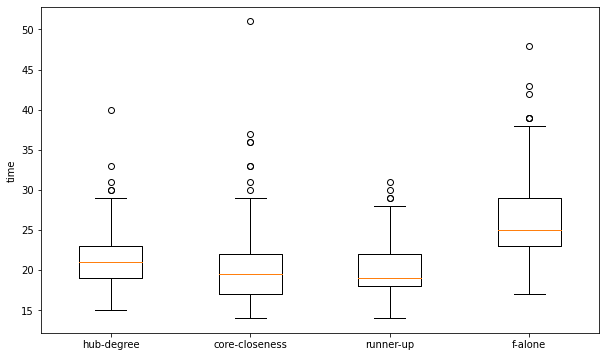

In [29]:
fig = plt.figure(figsize=sq_leaf)
ax = fig.gca()
ax.boxplot(performances)
ax.set_ylabel('time')
ax.set_xticklabels(champions_label)
plt.show()
leaf('champions-boxpplot')

***closeness centrality seem to better perform fake news spreading rather than node degree***

let's spread fake news inside communities

In [30]:
performances = {i:[] for i in range(how_many)}
for _ in range(2000):
    champion = random.choice(list(people.nodes))
    spread_time = len(simulation(people, champion))
    performances[communities[champion]].append(spread_time)

In [31]:
# list
performances = [i for i in list (performances.values())]
# trunk
performances = [performances[k][:min([len(i) for i in performances])] for k in range(len(performances))]

stats

In [32]:
list(zip(range(len(performances)), np.mean(performances, axis=1), np.std(performances, axis=1)))

# (community.no, average.performance, performances.deviation)

[(0, 21.989795918367346, 4.04185979106099),
 (1, 23.61904761904762, 4.868800203284289),
 (2, 22.482993197278912, 5.027615901499929),
 (3, 24.738095238095237, 5.0832636328443295)]

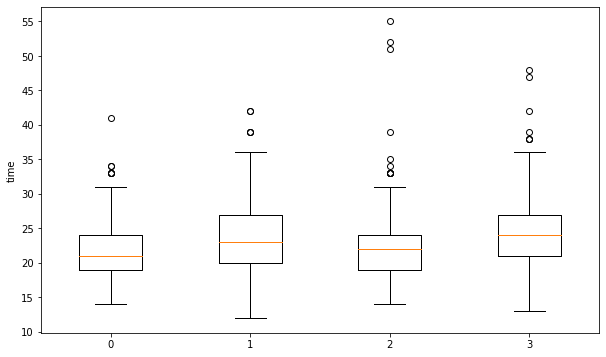

In [33]:
fig = plt.figure(figsize=sq_leaf)
ax = fig.gca()
ax.boxplot(performances)
ax.set_ylabel('time')
#ax.set_ylim(18,27)
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.set_xticklabels(list(range(how_many)))
plt.show()
leaf('performces-boxplot')

***fake news spreadind seems slower if patient-0 is inside community no. 3***

In [34]:
degree_4each_cluster = [[] for _ in range(how_many)]
for i in people.nodes:
    degree_4each_cluster[communities[i]].append(people.degree(i))

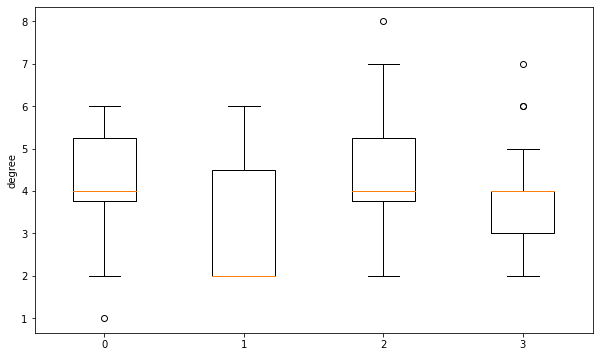

In [35]:
fig = plt.figure(figsize=sq_leaf)
ax = fig.gca()
ax.boxplot(degree_4each_cluster)
ax.set_ylabel('degree')
#ax.set_ylim(18,27)
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.set_xticklabels(list(range(how_many)))
plt.show()

In [36]:
close_4each_cluster = [[] for _ in range(how_many)]
for i in people.nodes:
    close_4each_cluster[communities[i]].append(close_dict[i])

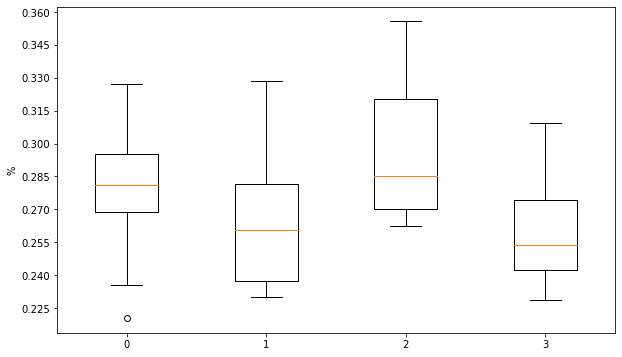

In [37]:
fig = plt.figure(figsize=sq_leaf)
ax = fig.gca()
ax.boxplot(close_4each_cluster)
ax.set_ylabel('%')
#ax.set_ylim(18,27)
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.set_xticklabels(list(range(how_many)))
plt.show()
leaf('closeness-boxplot')